# Data Collection

In [ ]:
pip install yfinance fredapi pandas requests matplotlib

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

# Set Google Drive path
drive_path = "/content/drive/My Drive/Thesis/Data_Collection/"
os.makedirs(drive_path, exist_ok=True)

# Define start and end dates
start_date = "2014-01-01"
end_date = "2023-12-31"

# Download VIX (Volatility Index)
vix = yf.download('^VIX', start=start_date, end=end_date)
vix.to_csv(drive_path + 'VIX_data.csv')

# Download S&P 500 Index Data
sp500 = yf.download('^GSPC', start=start_date, end=end_date)

# Print column names to check structure
print("S&P 500 Data Columns:", sp500.columns)

# Use "Close" instead of "Adj Close"
sp500['Returns'] = sp500['Close'].pct_change()
sp500['Historical_Volatility'] = sp500['Returns'].rolling(window=30).std() * np.sqrt(252)  # Annualized volatility

# Save data
sp500.to_csv(drive_path + 'SP500_data.csv')
sp500[['Historical_Volatility']].dropna().to_csv(drive_path + 'Historical_Volatility.csv')

print("Financial data (VIX, S&P 500, Historical Volatility) saved successfully in Google Drive!")


In [ ]:
from fredapi import Fred

# Paste your actual API key here (must be exactly 32 characters)
API_KEY = "7148259fc5ed9181be81fcc64b2bc952"

# Check if API key is valid
if len(API_KEY) != 32 or not API_KEY.isalnum() or not API_KEY.islower():
    print("ERROR: Your FRED API Key is not valid! Check and try again.")
else:
    print(f"API Key is valid! Length: {len(API_KEY)} characters.")

# Initialize FRED API
fred = Fred(api_key=API_KEY)

# Define macroeconomic indicators
indicators = {
    "Interest_Rate": "FEDFUNDS",
    "Inflation": "CPIAUCSL",
    "GDP_Growth": "A191RL1Q225SBEA",
    "Unemployment_Rate": "UNRATE",
    "Money_Supply": "M2SL",
    "TED_Spread": "TEDRATE"
}

# Fetch and save each indicator
for name, code in indicators.items():
    try:
        data = fred.get_series(code, start="2013-01-01", end="2023-12-31")
        if data is None:
            raise ValueError("No data returned for this indicator.")
        df = pd.DataFrame(data, columns=[name])
        df.index.name = "Date"
        df.to_csv(f"{drive_path}{name}.csv")
        print(f"{name} data saved in Google Drive!")
    except Exception as e:
        print(f"Error fetching {name}: {e}")

print("All macroeconomic data collected and stored in Google Drive!")


In [ ]:
# Load datasets from Google Drive
vix = pd.read_csv(drive_path + "VIX_data.csv", parse_dates=["Date"])
sp500 = pd.read_csv(drive_path + "SP500_data.csv", parse_dates=["Date"])
historical_vol = pd.read_csv(drive_path + "Historical_Volatility.csv", parse_dates=["Date"])

# Load macroeconomic data
macro_dfs = []
for name in indicators.keys():
    df = pd.read_csv(f"{drive_path}{name}.csv", parse_dates=["Date"])
    macro_dfs.append(df)

# Merge all macroeconomic data
macro_data = macro_dfs[0]
for df in macro_dfs[1:]:
    macro_data = pd.merge(macro_data, df, on="Date", how="outer")

# Merge everything into a single dataset
merged_df = vix[["Date", "Close"]].rename(columns={"Close": "VIX"})  # Using "Close" instead of "Adj Close"
merged_df = pd.merge(merged_df, sp500[["Date", "Close"]].rename(columns={"Close": "S&P500"}), on="Date", how="inner")
merged_df = pd.merge(merged_df, historical_vol, on="Date", how="inner")
merged_df = pd.merge(merged_df, macro_data, on="Date", how="inner")

# Save final dataset to Google Drive
merged_df.to_csv(drive_path + "merged_data.csv", index=False)

print("All datasets merged and saved in Google Drive as 'merged_data.csv'!")

# Preprocessing

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv(drive_path + "merged_data.csv", parse_dates=["Date"])

# Show basic info
print("\n Dataset Overview:")
print(df.info())

# Display the first few rows
print("\n Sample Data:")
print(df.head())



 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   2016 non-null   datetime64[ns]
 1   VIX                    2016 non-null   float64       
 2   S&P500                 2016 non-null   float64       
 3   Historical_Volatility  2016 non-null   float64       
 4   Interest_Rate          78 non-null     float64       
 5   Inflation              78 non-null     float64       
 6   GDP_Growth             20 non-null     float64       
 7   Unemployment_Rate      78 non-null     float64       
 8   Money_Supply           78 non-null     float64       
 9   TED_Spread             1949 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 157.6 KB
None

 Sample Data:
        Date    VIX       S&P500  Historical_Volatility  Interest_Rate  \
0 2014-02-

In [ ]:
# Check missing values
print("\n Missing Values Before Cleaning:")
print(df.isnull().sum())

# Forward-fill macroeconomic data (for monthly/quarterly data)
df.fillna(method='ffill', inplace=True)

# Drop remaining rows with missing values
df.dropna(inplace=True)

# Check missing values again
print("\n Missing Values After Cleaning:")
print(df.isnull().sum())



🔍 Missing Values Before Cleaning:
Date                        0
VIX                         0
S&P500                      0
Historical_Volatility       0
Interest_Rate            1938
Inflation                1938
GDP_Growth               1996
Unemployment_Rate        1938
Money_Supply             1938
TED_Spread                 67
dtype: int64

 Missing Values After Cleaning:
Date                     0
VIX                      0
S&P500                   0
Historical_Volatility    0
Interest_Rate            0
Inflation                0
GDP_Growth               0
Unemployment_Rate        0
Money_Supply             0
TED_Spread               0
dtype: int64


<ipython-input-99-9c4119d0d3f5>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Select only numerical columns (excluding Date)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Initialize StandardScaler
scaler = StandardScaler()

# Apply normalization
df[num_cols] = scaler.fit_transform(df[num_cols])

# Save the scaled dataset
df.to_csv(drive_path + "preprocessed_data.csv", index=False)

print("Data Normalized and Saved as 'preprocessed_data.csv' in Google Drive!")


✅ Data Normalized and Saved as 'preprocessed_data.csv' in Google Drive!


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


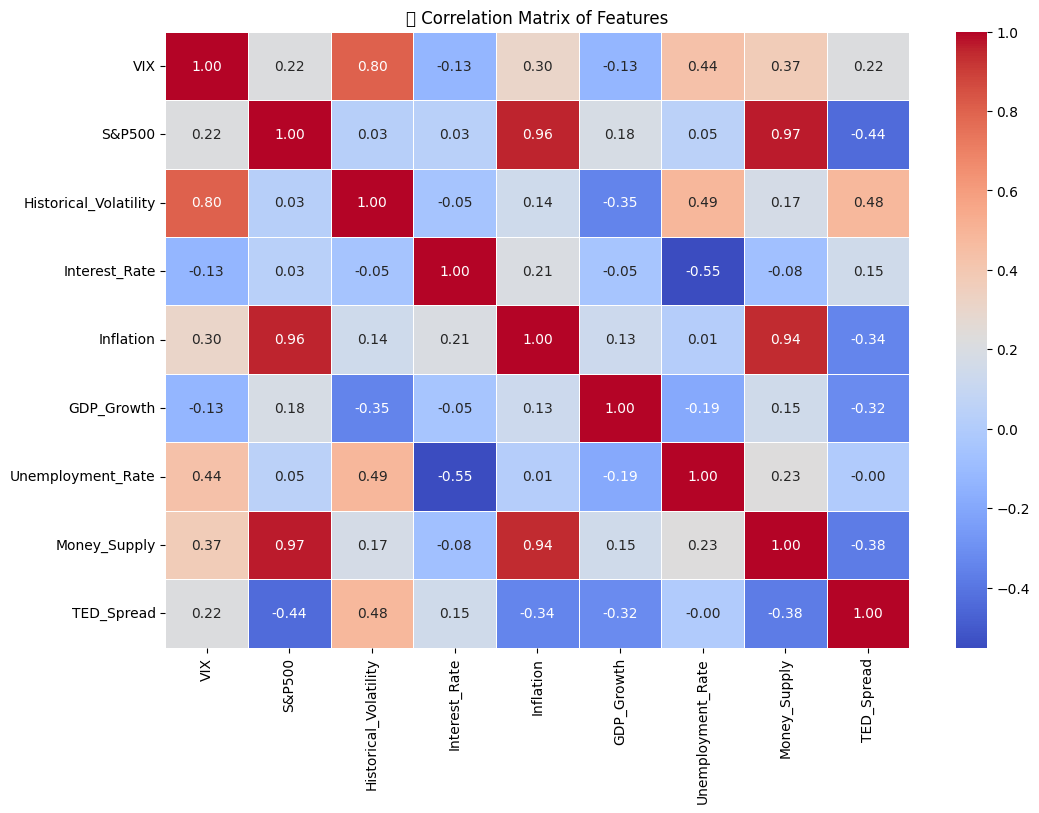

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()
